# "Cross-validation" des modèles

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Hyper-parametres
learning_rate = 0.04
num_epochs = 400
N = 100
N_cv = 40
seed = 42
batch_size = N//4
#batch_size = N//2
N_test = 0
N_test = 1000
N_scan = 9
bias = True


p0 = 0.05 #lapse rate
theta0 = 0
wt = np.pi/20
theta_std = np.pi/6



## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = p0,
            theta0 = theta0,
            wt = wt,
            theta_std = theta_std,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p #add lapse rate
    y = np.random.rand(N) < p #generate data
    return theta, p, y

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-2): #-2 ?
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))

    def forward(self, theta):
        out = self.logit0.sigmoid()/2 + (1-self.logit0.sigmoid())*self.linear(theta).sigmoid()
        return out
        

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [5]:
torch.sigmoid(torch.tensor([-3.]))

tensor([0.0474])

In [6]:
%%timeit
theta, p, y = get_data()

40.8 µs ± 475 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [7]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y,verbose=True) 

Iteration: 0 - Loss: 0.68397
Iteration: 12 - Loss: 0.61987
Iteration: 24 - Loss: 0.57180
Iteration: 36 - Loss: 0.53603
Iteration: 48 - Loss: 0.50966
Iteration: 60 - Loss: 0.49025
Iteration: 72 - Loss: 0.47558
Iteration: 84 - Loss: 0.46454
Iteration: 96 - Loss: 0.45594
Iteration: 108 - Loss: 0.44936
Iteration: 120 - Loss: 0.44417
Iteration: 132 - Loss: 0.44005
Iteration: 144 - Loss: 0.43683
Iteration: 156 - Loss: 0.43434
Iteration: 168 - Loss: 0.43226
Iteration: 180 - Loss: 0.43062
Iteration: 192 - Loss: 0.42929
Iteration: 204 - Loss: 0.42827
Iteration: 216 - Loss: 0.42747
Iteration: 228 - Loss: 0.42694
Iteration: 240 - Loss: 0.42630
Iteration: 252 - Loss: 0.42593
Iteration: 264 - Loss: 0.42557
Iteration: 276 - Loss: 0.42530
Iteration: 288 - Loss: 0.42510
Iteration: 300 - Loss: 0.42504
Iteration: 312 - Loss: 0.42483
Iteration: 324 - Loss: 0.42470
Iteration: 336 - Loss: 0.42463
Iteration: 348 - Loss: 0.42457
Iteration: 360 - Loss: 0.42451
Iteration: 372 - Loss: 0.42456
Iteration: 384 - L

In [8]:
with torch.no_grad():
    if bias: print('bias', logistic_model.linear.bias.item())
    print('slope', logistic_model.linear.weight.item())    
    print('p0', torch.sigmoid(logistic_model.logit0).item())


bias 0.01772402909160355
slope 4.908476725057404
p0 0.0013175371722360133


loss= 0.424450247491


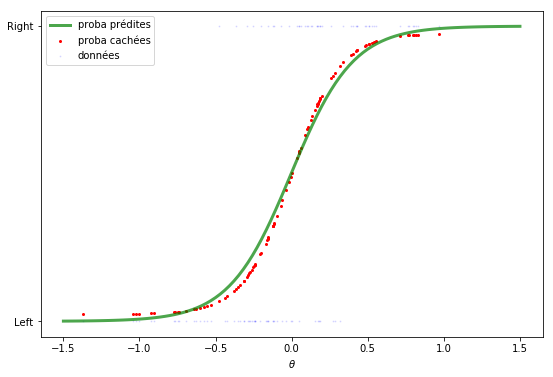

In [9]:
print('loss=', loss)
plt.figure(figsize = (9,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [10]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

2.22 s ± 72.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.4244, grad_fn=<BinaryCrossEntropyBackward>)


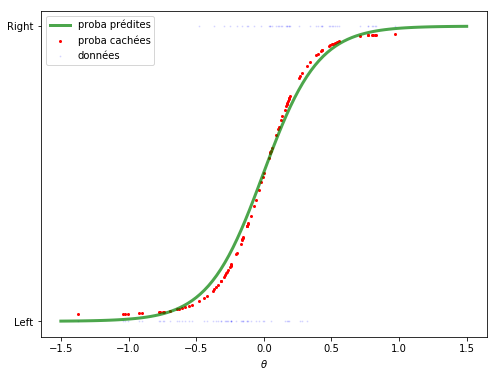

In [11]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [12]:
Ns = np.logspace(1, 3, N_scan, base=10)

Ns_, losses, loss_Ps, loss_P0s = [], [], [], []

for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)
    

N: 10, Loss: 0.50191, loss_P: 0.49376, loss_P0: 0.38791
N: 17, Loss: 0.44292, loss_P: 0.43854, loss_P0: 0.38791
N: 31, Loss: 0.39036, loss_P: 0.39555, loss_P0: 0.38791
N: 56, Loss: 0.38422, loss_P: 0.39295, loss_P0: 0.38791
N: 100, Loss: 0.38552, loss_P: 0.39182, loss_P0: 0.38791
N: 177, Loss: 0.39091, loss_P: 0.39431, loss_P0: 0.38791
N: 316, Loss: 0.38555, loss_P: 0.38898, loss_P0: 0.38791
N: 562, Loss: 0.38261, loss_P: 0.38944, loss_P0: 0.38791
N: 1000, Loss: 0.38201, loss_P: 0.39001, loss_P0: 0.38791


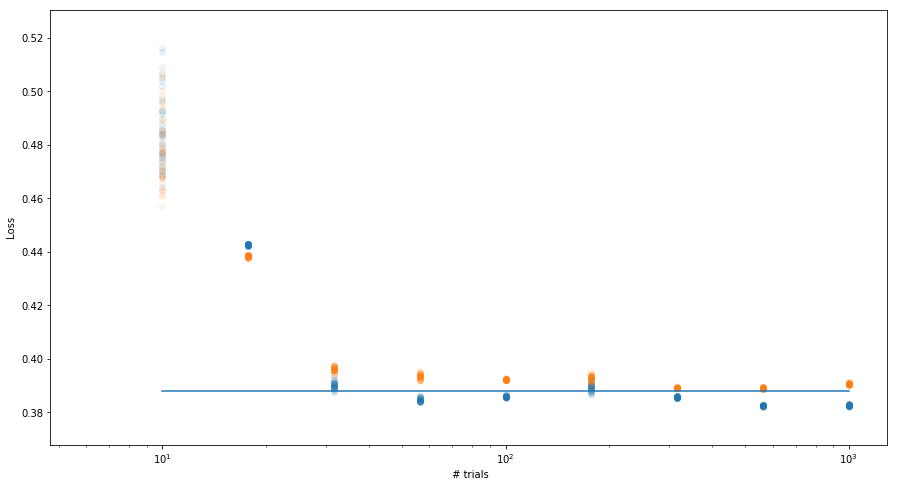

In [13]:
#plot

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

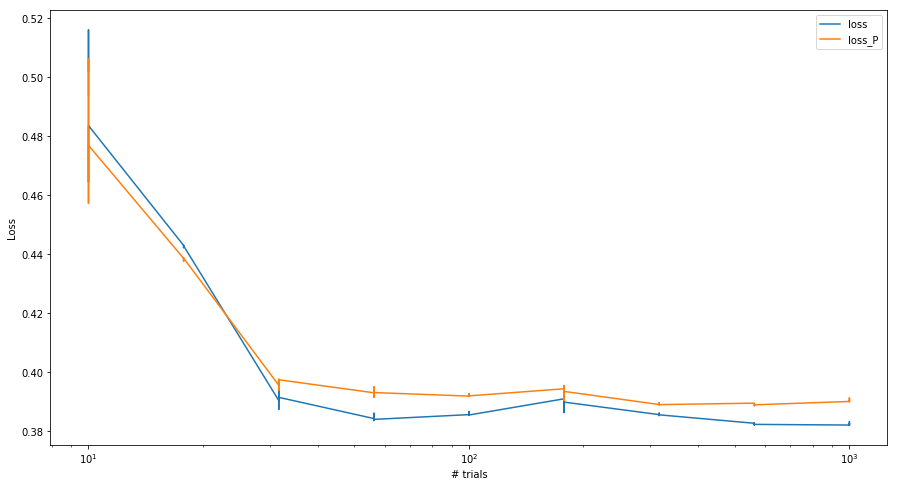

In [14]:
#figure pas très utile...juste une meilleure "visualisation"

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.plot(Ns_,losses,label='loss')
ax.plot(Ns_, loss_Ps, label='loss_P')
#ax.plot(Ns_, loss_P0s, label='loss_P0')
ax.set_xscale('log') #hum.
plt.xlabel("# trials")
plt.ylabel("Loss")
plt.legend()
plt.show()

 ### Données générées vs predictions

In [15]:
#theta0 prediction/generate

theta0s = np.random.randn(50)
theta0_s = []

for theta0_predict in theta0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        
        theta0_predict = logistic_model.linear.bias.item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f" Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}, theta0: {theta0_predict:.5f}")
        loss_P0s.append(loss_P0)
        theta0_s.append(theta0_predict)
        loss_Ps.append(loss_P)
        losses.append(loss)

 Loss: 0.38274, loss_P: 0.39076, loss_P0: 0.38791, theta0: -0.11725
 Loss: 0.38285, loss_P: 0.39089, loss_P0: 0.38791, theta0: -0.11625
 Loss: 0.38290, loss_P: 0.39094, loss_P0: 0.38791, theta0: -0.11529
 Loss: 0.38250, loss_P: 0.39046, loss_P0: 0.38791, theta0: -0.12010
 Loss: 0.38280, loss_P: 0.39078, loss_P0: 0.38791, theta0: -0.11331
 Loss: 0.38255, loss_P: 0.39047, loss_P0: 0.38791, theta0: -0.11508
 Loss: 0.38232, loss_P: 0.39026, loss_P0: 0.38791, theta0: -0.12226
 Loss: 0.38281, loss_P: 0.39081, loss_P0: 0.38791, theta0: -0.11527
 Loss: 0.38197, loss_P: 0.38995, loss_P0: 0.38791, theta0: -0.12876
 Loss: 0.38235, loss_P: 0.39029, loss_P0: 0.38791, theta0: -0.12177
 Loss: 0.38275, loss_P: 0.39074, loss_P0: 0.38791, theta0: -0.11594
 Loss: 0.38225, loss_P: 0.39015, loss_P0: 0.38791, theta0: -0.12001
 Loss: 0.38206, loss_P: 0.39001, loss_P0: 0.38791, theta0: -0.12549
 Loss: 0.38225, loss_P: 0.39020, loss_P0: 0.38791, theta0: -0.12211
 Loss: 0.38303, loss_P: 0.39110, loss_P0: 0.3879

## influence du nombre du learning rate


In [16]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.57369, loss_P: 0.57574, loss_P0: 0.38791
learning_rate: 0.00711, Loss: 0.46601, loss_P: 0.46935, loss_P0: 0.38791
learning_rate: 0.01265, Loss: 0.41506, loss_P: 0.41964, loss_P0: 0.38791
learning_rate: 0.02249, Loss: 0.39441, loss_P: 0.39982, loss_P0: 0.38791
learning_rate: 0.04000, Loss: 0.38569, loss_P: 0.39195, loss_P0: 0.38791
learning_rate: 0.07113, Loss: 0.38536, loss_P: 0.39201, loss_P0: 0.38791
learning_rate: 0.12649, Loss: 0.38557, loss_P: 0.39225, loss_P0: 0.38791
learning_rate: 0.22494, Loss: 0.38536, loss_P: 0.39229, loss_P0: 0.38791
learning_rate: 0.40000, Loss: 0.38559, loss_P: 0.39231, loss_P0: 0.38791


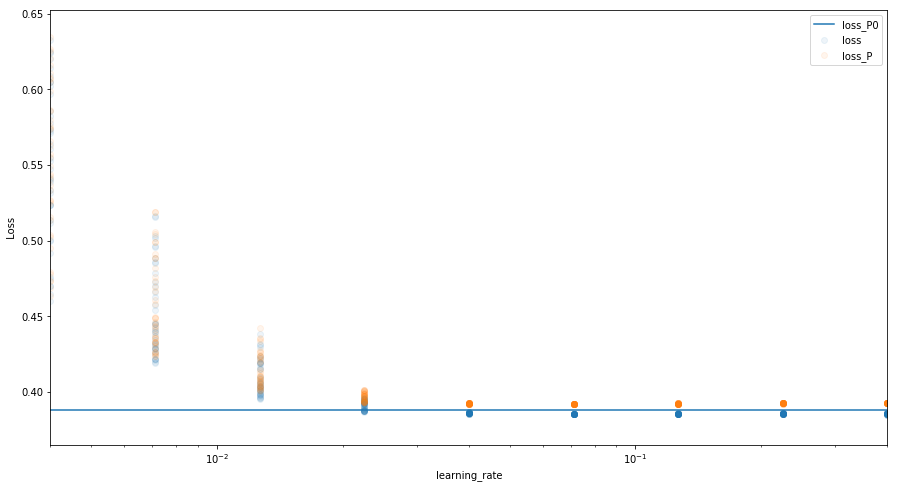

In [17]:
#influence du learning rate sur loss

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')
ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [18]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

num_epochs: 40, Loss: 0.54001, loss_P: 0.54240, loss_P0: 0.38791
num_epochs: 71, Loss: 0.49909, loss_P: 0.50210, loss_P0: 0.38791
num_epochs: 126, Loss: 0.39948, loss_P: 0.40459, loss_P0: 0.38791
num_epochs: 224, Loss: 0.38873, loss_P: 0.39457, loss_P0: 0.38791
num_epochs: 400, Loss: 0.38566, loss_P: 0.39204, loss_P0: 0.38791
num_epochs: 711, Loss: 0.38537, loss_P: 0.39208, loss_P0: 0.38791
num_epochs: 1264, Loss: 0.38553, loss_P: 0.39224, loss_P0: 0.38791
num_epochs: 2249, Loss: 0.38555, loss_P: 0.39236, loss_P0: 0.38791
num_epochs: 4000, Loss: 0.38551, loss_P: 0.39237, loss_P0: 0.38791


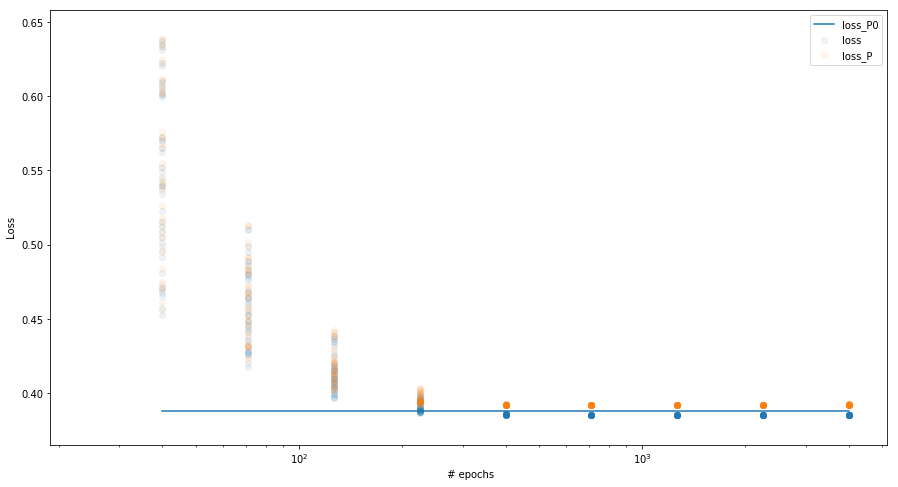

In [19]:
# influence du nbr d'epochs sur loss 
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochs')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [20]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

batch_size: 12, Loss: 0.38544, loss_P: 0.39198, loss_P0: 0.38791
batch_size: 16, Loss: 0.38591, loss_P: 0.39233, loss_P0: 0.38791
batch_size: 21, Loss: 0.38562, loss_P: 0.39218, loss_P0: 0.38791
batch_size: 27, Loss: 0.38589, loss_P: 0.39236, loss_P0: 0.38791
batch_size: 35, Loss: 0.38568, loss_P: 0.39191, loss_P0: 0.38791
batch_size: 45, Loss: 0.38586, loss_P: 0.39219, loss_P0: 0.38791
batch_size: 59, Loss: 0.38609, loss_P: 0.39226, loss_P0: 0.38791
batch_size: 77, Loss: 0.38713, loss_P: 0.39275, loss_P0: 0.38791
batch_size: 100, Loss: 0.38577, loss_P: 0.39217, loss_P0: 0.38791


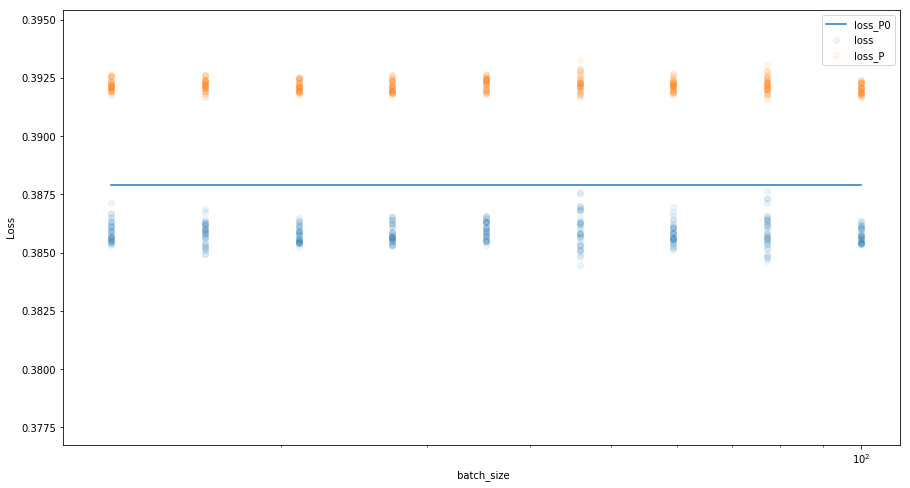

In [21]:
# influence de la taille du minibatch sur loss 

fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## Comparaison données générées/données prédites

In [22]:
# p0 prediction/generate

p0s = np.linspace(0,1,30)[:, None] #hum..
p0_s = []


for p0_predict in p0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])

        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()

        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        p0_predict = torch.sigmoid(logistic_model.logit0).item()
        

        if i_CV==0: print(f" Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}, p0 : {p0_predict: .5f}")
        loss_P0s.append(loss_P0)
        p0_s.append(p0_predict)
        loss_Ps.append(loss_P)
        losses.append(loss)



 Loss: 0.38230, loss_P: 0.39019, loss_P0: 0.38791, p0 :  0.01418
 Loss: 0.38228, loss_P: 0.39022, loss_P0: 0.38791, p0 :  0.01422
 Loss: 0.38207, loss_P: 0.39004, loss_P0: 0.38791, p0 :  0.01667
 Loss: 0.38250, loss_P: 0.39044, loss_P0: 0.38791, p0 :  0.01194
 Loss: 0.38269, loss_P: 0.39066, loss_P0: 0.38791, p0 :  0.01007
 Loss: 0.38203, loss_P: 0.38996, loss_P0: 0.38791, p0 :  0.01722
 Loss: 0.38260, loss_P: 0.39058, loss_P0: 0.38791, p0 :  0.01084
 Loss: 0.38251, loss_P: 0.39046, loss_P0: 0.38791, p0 :  0.01197
 Loss: 0.38213, loss_P: 0.39009, loss_P0: 0.38791, p0 :  0.01601
 Loss: 0.38233, loss_P: 0.39030, loss_P0: 0.38791, p0 :  0.01366
 Loss: 0.38259, loss_P: 0.39056, loss_P0: 0.38791, p0 :  0.01116
 Loss: 0.38267, loss_P: 0.39065, loss_P0: 0.38791, p0 :  0.01022
 Loss: 0.38235, loss_P: 0.39029, loss_P0: 0.38791, p0 :  0.01366
 Loss: 0.38199, loss_P: 0.38995, loss_P0: 0.38791, p0 :  0.01773
 Loss: 0.38271, loss_P: 0.39071, loss_P0: 0.38791, p0 :  0.00988
 Loss: 0.38207, loss_P: 0

In [32]:
len(p0_s)

1200

In [ ]:
#comparaison du p0 generate avec p0 prédit

figure, ax = plt.subplots(figsize = (15, 9)) 


p0_ = np.full(shape= 1200,fill_value = p0)

ax.scatter (p0_s,p0_)
ax.set_ylabel('po_generate')
ax.set_xlabel('p0_predict')

plt.legend()
plt.show()


In [26]:
#theta0 prediction/generate

theta0s = np.random.randn(30)
theta0_s = []

for theta0_predict in theta0s:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        
        theta0_predict = logistic_model.linear.bias.item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        if i_CV==0: print(f" Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}, theta0: {theta0_predict:.5f}")
        loss_P0s.append(loss_P0)
        theta0_s.append(theta0_predict)
        loss_Ps.append(loss_P)
        losses.append(loss)

 Loss: 0.38217, loss_P: 0.39010, loss_P0: 0.38791, theta0: -0.12351
 Loss: 0.38308, loss_P: 0.39118, loss_P0: 0.38791, theta0: -0.11365
 Loss: 0.38249, loss_P: 0.39044, loss_P0: 0.38791, theta0: -0.11774
 Loss: 0.38209, loss_P: 0.39008, loss_P0: 0.38791, theta0: -0.12769
 Loss: 0.38206, loss_P: 0.39005, loss_P0: 0.38791, theta0: -0.12838
 Loss: 0.38239, loss_P: 0.39032, loss_P0: 0.38791, theta0: -0.11975
 Loss: 0.38190, loss_P: 0.38989, loss_P0: 0.38791, theta0: -0.13049
 Loss: 0.38228, loss_P: 0.39021, loss_P0: 0.38791, theta0: -0.12113
 Loss: 0.38253, loss_P: 0.39052, loss_P0: 0.38791, theta0: -0.12055
 Loss: 0.38190, loss_P: 0.38988, loss_P0: 0.38791, theta0: -0.12930
 Loss: 0.38292, loss_P: 0.39095, loss_P0: 0.38791, theta0: -0.11432
 Loss: 0.38245, loss_P: 0.39041, loss_P0: 0.38791, theta0: -0.11919
 Loss: 0.38268, loss_P: 0.39068, loss_P0: 0.38791, theta0: -0.11784
 Loss: 0.38245, loss_P: 0.39040, loss_P0: 0.38791, theta0: -0.11947
 Loss: 0.38243, loss_P: 0.39034, loss_P0: 0.3879

In [35]:
len(theta0_s)

1200

In [ ]:
#comparaison du theta0 generate avec theta0 prédit


figure, ax = plt.subplots(figsize = (15, 9)) 

theta0_ = np.full(shape= 1200,fill_value = theta0)

ax.scatter(theta0_, theta0_s)
axes.set_xlabel('theta0_generate')
axes.set_ylabel('theta0_predict')

plt.legend()
plt.show()


In [ ]:
#wt prediction/generate

wts = np.linspace(0.1,0.5, 20)
wt_s = []

for wt_predict in wts:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
    
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        
        wt_predict = logistic_model.linear.weight.item()
        
        if i_CV==0: print(f" Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}, wt:{wt_predict:.5f}")
        loss_P0s.append(loss_P0)
        wt_s.append(wt_predict)
        loss_Ps.append(loss_P)
        losses.append(loss)

 Loss: 0.38257, loss_P: 0.39051, loss_P0: 0.38791, wt:5.57574


In [ ]:
#comparaison du wt generate avec wt prédit

figure, ax = plt.subplots(figsize = (15, 9)) 

wt_ = np.full(shape= 1200,fill_value = wt ,dtype=np.int)


ax.scatter(wt_, wt_s)
#ax.scatter(wt, wt_s, label='p0')
axes.set_xlabel('wt_generate')
axes.set_ylabel('wt_predict')

plt.legend()
plt.show()
